# This code post-processes the experiment data of SD7003
**ensemble average, no filter, save as individual raw runs**
- there are 10 runs for each case, case a, c, d, f have 3 cycles, while case b, e have 6 cycles
- so case a, c, d, f have 30 cycles, and case b, e have 60 cycles in total for individual runs
- include phase average. save the phase data and the individual raw data
- uncertainty:
    - δCp = sqrt((∂Cp/∂p * δlift)^2 + (∂Cp/∂rho * δrho)^2 + (∂Cp/∂u * δu)^2)

# Prepare

In [1]:
# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [2]:
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv

from scipy.signal import filtfilt
from scipy.signal import bessel
b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)

cm2in = 1/2.54           # conversion of in to cm
plt.rcParams.update({"font.size": 8})
plt.rcParams['lines.markersize'] ** 5 # set default marker size

Chord     = 0.2              # chord length, m
dChord    = 0.001
len_span  = 0.9
dlen_span = 0.01
Span   = Chord*len_span        # airfoil surface area
dSpan  = dChord*dlen_span
rho  = 998               # kg/m^3
drho = 10
u    = 0.3               # m/s
du   = 0.01

dynP = (0.5*rho*u**2)  # dynamic pressure

Color = ['#9d1939', '#0b1f38', '#eebd31', '#9d1939', '#0b1f38', '#eebd31']

def myCases(c):
    if c == 'A':
        Color = '#9d1939'
        Icon  = '.'
    if c == 'B':
        Color = '#0b1f38'
        Icon  = '.'
    if c == 'C':
        Color = '#eebd31' 
        Icon  = '.'
    if c == 'D':
        Color = '#9d1939'
        Icon  = '-'
    if c == 'E':
        Color = '#0b1f38'
        Icon  = '-'
    if c == 'F':
        Color = '#eebd31'
        Icon  = '-'
    
    return Icon,Color 


# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def reduceToOnePeriod(data,npoints):
    nPoints = np.size(data,axis=0)      # number of points in the original data-set
    nCycles = int(nPoints/npoints) # total number of cycles
    
    onePeriod = np.zeros(npoints)    # data that is 1-period long
    startp = 0
    endp   = npoints
    for n in range(nCycles):
        onePeriod = onePeriod + data[startp:endp]
        startp = startp + npoints
        endp   = startp + npoints
    
    onePeriod = onePeriod/nCycles  # mean of all the cycles

    return onePeriod

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Location of pressure ports:
xports = [0,0.04,0.08,0.12,0.16,0.2,0.24,0.28, 0.32, 0.36, 0.405, 0.5, 0.6, 0.7, 0.8] # frequencies of the motion

# corrector factors for all sensors:
fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]

# Import coordinates of SD7003:
SD7003 = pd.read_csv('./inputs/reference/SD7003_coord.csv', skiprows=1, sep=',', usecols = [0,1]).to_numpy()
SD7003[:,1] = SD7003[:,1]*6
xs, ys = zip(*SD7003) #create lists of x and y values

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

print("\n==> This code runs OK")


==> This code runs OK


## plot force coefficients for steady case
Notice that:
- A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

In [ ]:
import pandas as pd
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

num_files  = 16     # number of force-coefs files
Alpha0 = 8

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Folder = './inputs/experiments/Steady/AoA' + str(Alpha0) + '/'
nt         = 9000 # length of data
filterFreq = 0.5     # cut-off frequency for filter
dAlpha     = 0     # changes in AoA
RefFreq    = 0     # frequency of the motion

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Import data:
data_raw = {}
for i in range(num_files):
    # import initial data
    fileName = 'Initial_Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[2,4,7], nrows=nt).to_numpy() # transform data to numpy array
    idata = np.mean(idata,axis=0)

    # Import the force data:
    fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    data = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[0,2,4,7], names= ["id","fx","fy","mz"]) 
    
    # group data with the same time-stamps
    time = np.arange(0,nt,1)/1000     # create time-vector: ms -> s
    data_raw[i] = data[["fx","fy","mz"]].copy().to_numpy() # transform data to numpy array

    # Calculate average of the solution:
    if i==0:
        Data = np.zeros((nt,3))
    else:
        Data = Data + data_raw[i][0:nt,:] - idata
# calculate the mean force between experiments
Forces_ = Data/num_files # "fx","fy","mz"

# Fix force coefficient values based of the AoA:
AoA  = Alpha0*np.pi/180 # angle of attack, alpha = alpha(t)

Forces = np.zeros((nt,3)) 
for t in range(nt):
    c, s = np.cos(AoA), np.sin(AoA)
    R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
    Forces[t,:] = R.dot(Forces_[t,:])
Forces[:,2]  = Forces_[:,2] # no need to transform mz

# now they are drag, lift, moment
Forces_[:,:] = Forces[:,:] # fix AoA in original data, Forces_, too.

# Calculate force coefficients: cd, cl, cm
forceCoefs_ = Forces_/(dynP*Span)
forceCoefs_[:,2] = forceCoefs_[:,2]/Chord

# plot cd, cl, cm
names  = ['$C_D$', '$C_L$', '$CM_z$']
limits = [-0.2, 0.5, 0.0, 1.1, -0.1, 0.05]

axs = plt.figure(figsize=(17*cm2in, 5*cm2in)).subplots(1,3)
plt.rcParams['font.size'] = '8'

i = 0
j = 0
for ax in axs.flat:
    ax.plot(time, forceCoefs_[:,i], '-', color='#111D5E' )
    ax.set(ylabel=names[i])
    #ax.set_ylim(limits[j], limits[j+1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_xlim([0, 6])
    #ax.legend(loc='best')
    ax.set(xlabel='$t$ (s)')
    i=i+1   
    j=j+2
plt.tight_layout()

# Calculate lift and drag coefficients:
CD_Mean = np.mean(forceCoefs_[-1000:-1,0])
CL_Mean = np.mean(forceCoefs_[-1000:-1,1])
CM_Mean = np.mean(forceCoefs_[-1000:-1,2])

#plt.show()
plt.savefig('./Outputs/ForceCoefess_Steady.png', bbox_inches='tight', dpi=450)

print("CD:" + f'{CD_Mean:0.3f}')
print("CL:" + f'{CL_Mean:0.3f}')
print("CM:" + f'{CM_Mean:0.3f}')

### Force coefficients vs AoA
Notice that:
 - A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
labels = ['drag','lift']
i = 0
for ax in axs.flat:
    ax.plot(Forces_[0:,i],label=labels[i])
    ax.legend()
    i = i+1

In [ ]:
# calculate the std of the loads, prepare for the uncertainty calculation
Forces_.shape
stds_force = np.std(Forces_[5000:,:], axis=0)
stds_force

In [ ]:
# Import experiments data:
data = pd.read_csv('./inputs/experiments/Steady/ForceCoeffs_vs_AoA.txt', skiprows=0, sep=',').to_numpy()

Chord     = 0.2              # chord length, m
dChord    = 0.001
len_span  = 0.95
dlen_span = 0.02
Span   = Chord*len_span        # airfoil surface area
dSpan  = dChord*dlen_span
rho  = 998               # kg/m^3
drho = 10
u    = 0.3               # m/s
du   = 0.01

# Calculate loads using coefficient (with uncertainty)
# uncertainty: u(F) = sqrt(u_sys^2 + u_rand^2)
# nano25 ip65/68: resolution: 1/24, range:250N
# uncertainty due to the resolution: 1/48N (half of resolution);
# assume the systematic uncertainty is 0.1%: 0.25N
# and the standard deviation
drag   = data[:,1]*(0.5*rho*u**2*Span)
d_drag = np.sqrt((1/48)**2 + (0.25)**2 + (stds_force[0])**2)

lift   = data[:,2]*(0.5*rho*u**2*Span)
d_lift = np.sqrt((1/48)**2 + (0.25)**2 + (stds_force[1])**2)

cd   = drag / (0.5*rho*u**2*Span)
# d_cd = (d_drag/drag) + 2*(drho/rho) + (du/u) + 2*(dSpan/Span)
d_cd   = np.sqrt((1 / (0.5 * rho * u**2 * Span) * d_drag) ** 2 + 
                 (drag / ( 0.5 * rho**2 * u**2 * Span) * drho) ** 2 + 
                 (2*drag / (0.5 * rho * u**3 * Span) * du) ** 2 + 
                 (drag / ( 0.5 * rho * u**2 * Span**2) * dSpan) ** 2)

cl   = lift / (0.5*rho*u**2*Span)
# d_cl = (d_lift/lift) + 2*(drho/rho) + (du/u) + 2*(dSpan/Span)
d_cl   = np.sqrt((1 / (0.5 * rho * u**2 * Span) * d_lift) ** 2 + 
                 (lift / ( 0.5 * rho**2 * u**2 * Span) * drho) ** 2 + 
                 (2*lift / (0.5 * rho * u**3 * Span) * du) ** 2 + 
                 (lift / ( 0.5 * rho * u**2 * Span**2) * dSpan) ** 2)

load   = {}
d_load = {}
load[0] = cd
load[1] = cl
d_load[0] = d_cd
d_load[1] = d_cl

# Import reference data:
Folder = './inputs/reference/AirfoilDataBase_'
infile = ['CD','CL','CM'] # name of the ref-file we will open
limits = [0, 0.1, -0.1, 1.2, -0.06, 0.06]

axs    = plt.figure(figsize=(16*cm2in, 6.5*cm2in)).subplots(1,2)
names  = ['$C_D$', '$C_L$', '$CM_z$']
colors = ['darkorange','teal']

i = 0
j = 0
for ax in axs.flat:
    ax.xaxis.get_label().set_fontsize(8)
    ax.yaxis.get_label().set_fontsize(8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(ylabel=names[i], fontsize = 8)
    ax.set_xlabel(r'$\alpha$ $(\circ)$', fontsize = 8)
    ax.set_xlim([-1, 12])
    # ax.set_ylim(limits[j], limits[j+1])

    # Plot reference data:
    refFile = pd.read_csv(Folder+infile[i]+'_vs_AoA.csv', skiprows=1, sep=',').to_numpy()
    ax.plot(refFile[:,0], refFile[:,1], '-.', color='#111D5E', linewidth=1.8,label='XFOIL, Ncr=9' )

    # Plot experimental data data:
    ax.plot(data[:,0], data[:,i+1],'o', markersize=2, markerfacecolor='#9d1939', linewidth=1.8, markeredgecolor='#000000', label='Exp. (2021) (QU)' )
    ax.errorbar(data[:,0], load[i], yerr=d_load[i]*load[i], fmt='o', ecolor='#9d1939', markersize=5,
                markerfacecolor='#9d1939', markeredgecolor='#000000', capsize=5)

    i=i+1
    j=j+2

ax.legend(ncol=1 , loc='upper center', bbox_to_anchor=(0.81, 0.46))

plt.tight_layout()

plt.savefig('./outputs/ForceCoefess_vs_AoA.png', bbox_inches='tight', dpi=450)

### **Plot force coefficients for dynamic cases**

Use the following parametes:
- Case 'A':
    - pitching
    - num_files: 16
    - RefFreq: 0.19
    - dAlpha:  4.5 
- Case 'B':
    - pitching
    - num_files: 16
    - RefFreq: 0.38
    - dAlpha:  4.5 
- Case 'C':
    - pitching
    - num_files: 10
    - RefFreq: 0.19
    - dAlpha:  6.0
- Case 'D':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0  
- Case 'E':
    - plunging
    - num_files: 11
    - RefFreq: 0.38
    - dAlpha:  0 
- Case 'F':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0 
    

**for force,**  
**nMotionStart = 17100**  

**for pressure,**  
**case A,B,C: nMotionStart=17600**  
**case D,E,F: nMotionStart=17300**  

**FOR AOA:**  
**nMotionStart = 17000**

In [11]:
# * * * * * * * * * * * * * *
Case       = ['A','B','C','D','E','F']
num_files  = 10    # number of runs for each case; they should have the same runs for post-process
RefFreq    = np.array([0.19, 0.38, 0.19, 0.19, 0.38, 0.19])  # reference frequency, for normalization
dAlpha     = 4.5   # change in AoA: p-to-p, deg
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
nt     = 190   # length of data
Period       = 37 #s, time-interval of analysis
len_period   = int((1/0.19)*1000)-1 # =5262, -1 is useful for later calculation; length of one period; samples number
nMotionStart = 17000 # motion starts at this index/instant
nDataPoints  = 17000+5262*3+(17100-17000) # total number of data points; three periods can be used
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
# Define AoA:
# Create real-motion profile:
MotionTime = np.linspace(0,Period,nDataPoints)
Alpha0 = 8.0   # mean AoA, deg
Omega  = 2*np.pi*RefFreq
AoA    = np.zeros((nDataPoints,6))
movTime = MotionTime[nMotionStart:nDataPoints] - MotionTime[nMotionStart]
for i in range(6):
    AoA[0:nMotionStart,i] = Alpha0*np.pi/180    # AoA(t<t0) = Alpha0, before pitching or plunging
    AoA[nMotionStart:nDataPoints,i]  = ( Alpha0 + dAlpha*np.sin( Omega[i]*(movTime) ) )*np.pi/180
# * * * * * * * * * * * * * *

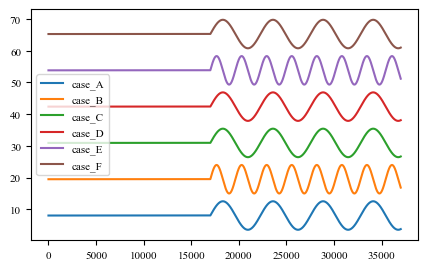

In [4]:
fig,ax = plt.subplots(figsize=(5,3))
for i in range(6):
    ax.plot((AoA[:,i]+0.2*i)*180/np.pi, label='case_'+Case[i]) # add +0.2*i to distinguish them
ax.legend()

In [18]:
data_raw    = {} # initialize a dictionary, with keys and values
forceCoefs_ = {}
data_global = {}
data_f_individual = {}
# * * * * * * * * * * * * * *
# import data
for k in Case: # loop to read all the six cases
    Folder = './inputs/experiments/Case' + k + '/' # where files are stored
    print(Folder)
    for i in range(num_files): # loop to read all the six cases
        data_global[k,i] = np.zeros((nDataPoints,3))
        # Import the initial data
        fileName = 'Initial_Force_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, sep=',', usecols=[2,4,7], nrows=5000).to_numpy() # [2,4,7] = "fx","fy","mz"
        idata    = np.mean(idata,axis=0) # take only the average forward

        # Rotate the initial data to the global reference frame: 
        # ALL pitching and plunging cases need do this
        c, s = np.cos(AoA[0,0]), np.sin(AoA[0,0])
        R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
        idata = R.dot(idata)

        # Import the force data:
        fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[0,2,4,7], names= ["id","fx","fy","mz"])
        data = data_raw[k,i][["fx","fy","mz"]].copy().to_numpy() # transform data to numpy array

        # Fix for correct AoA:
        nMotionStart = 17100
        nDataPoints  = nMotionStart + len_period*3
        for idx in range(nDataPoints):
            # find index, idx, of the time that "time" corresponds to in the airfoil's motion
            
            # for pitching cases: 'A', 'B', 'C', we need to transform the initial data to the global reference frame:
            if k == 'A':
                c, s = np.cos(AoA[idx,0]), np.sin(AoA[idx,0])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[k,i][idx,:] = R.dot(data[idx,:]) - idata
            elif k == 'B':
                c, s = np.cos(AoA[idx,1]), np.sin(AoA[idx,1])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[k,i][idx,:] = R.dot(data[idx,:]) - idata
            elif k == 'C':
                c, s = np.cos(AoA[idx,2]), np.sin(AoA[idx,2])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[k,i][idx,:] = R.dot(data[idx,:]) - idata
            # for plunging cases: 'D', 'E', 'F', no need to transform
            else:
                data_global[k,i][idx,:] = data[idx,:] - idata
        
        # Calculate average of the solution:
        if i==0:
            Data = np.zeros((nDataPoints,3))
        else:
            Data = Data + data_global[k,i][:,:]
            
    # combine the force coefficient individual runs
    if k in ['A','C','D','F']: # with three cycles, but only use the 2nd and the 3rd cycle, as the first one needs acceleration
        data_f_individual[k] = data_global[k,0][nMotionStart+len_period:nDataPoints,:]
        for j in range(1,num_files):
            data_f_individual[k] = np.concatenate((data_f_individual[k], data_global[k,j][nMotionStart+len_period:nDataPoints,:]), axis=0)

        Forces_ = Data/num_files # Calculate the mean:
        Forces_ = Forces_[nMotionStart+len_period:nDataPoints] # only save the data with pitching motion
        # * * * * * * * * * * * * * *

        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # calculate force coefficient

        # for individual run
        data_f_individual[k]      = data_f_individual[k]/(dynP*Span)
        data_f_individual[k][:,2] = data_f_individual[k][:,2]/Chord

        # for mean value
        forceCoefs_[k]      = Forces_/(dynP*Span)
        forceCoefs_[k][:,2] = forceCoefs_[k][:,2]/Chord
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
    else: # for case 'B','E', they have 6 cycles, but only use the last five, ignoring the 1st cycle
        data_f_individual[k] = data_global[k,0][nMotionStart+int(len_period/2):nDataPoints,:]
        for j in range(1,num_files):
            data_f_individual[k] = np.concatenate((data_f_individual[k], data_global[k,j][nMotionStart+int(len_period/2):nDataPoints,:]), axis=0)

        Forces_ = Data/num_files # Calculate the mean:
        Forces_ = Forces_[nMotionStart+int(len_period/2):nDataPoints] # only save the data with pitching motion
        # * * * * * * * * * * * * * *

        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # calculate force coefficient

        # for individual run
        data_f_individual[k]      = data_f_individual[k]/(dynP*Span)
        data_f_individual[k][:,2] = data_f_individual[k][:,2]/Chord

        # for mean value
        forceCoefs_[k]      = Forces_/(dynP*Span)
        forceCoefs_[k][:,2] = forceCoefs_[k][:,2]/Chord
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * *
    
# * * * * * * * * * * * * * *

# rename forceCoefs_ to CN
CN = forceCoefs_

print("\n==> This code runs OK")

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/

==> This code runs OK


**check the individual runs**

Text(0.5, 1.2, 'case B')

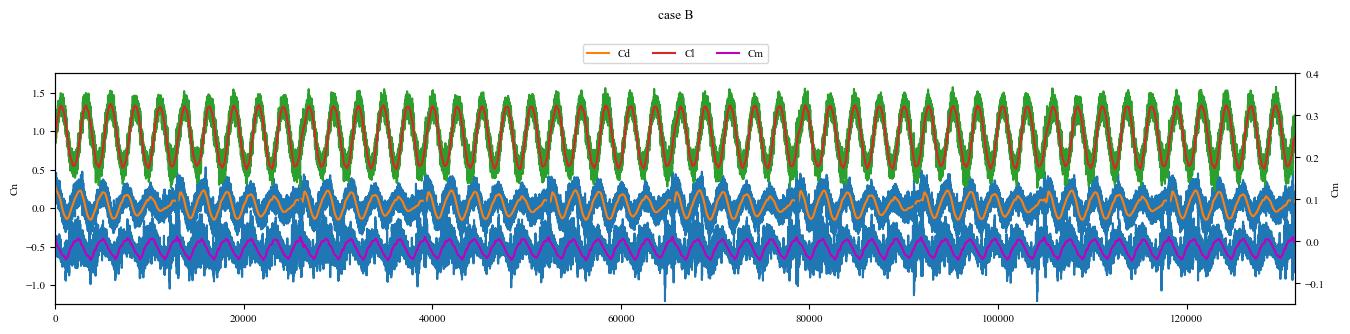

In [45]:
case_to_show = 'B'
fig, ax = plt.subplots(figsize=(16,3))
temppp_cd = filtfilt(b, a, data_f_individual[case_to_show][:,0])
temppp_cl = filtfilt(b, a, data_f_individual[case_to_show][:,1])
temppp_cm = filtfilt(b, a, data_f_individual[case_to_show][:,2])
ax.plot(data_f_individual[case_to_show][:,0])
line1 = ax.plot(temppp_cd, label='Cd')
ax.plot(data_f_individual[case_to_show][:,1])
line2 = ax.plot(temppp_cl, label='Cl')
ax.set_ylim([-1.25,1.75])
ax.set_ylabel('Cn')
ax_r = ax.twinx()
ax_r.plot(data_f_individual[case_to_show][:,2])
line3 = ax_r.plot(temppp_cm, color='m', label='Cm')
ax_r.set_ylim([-0.35+0.2,0.2+0.2])
ax_r.set_ylabel('Cm')
ax.margins(x=0)
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
legend = ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_title('case ' + case_to_show, loc='center', y=1.2)
# ax.set_xlim([0,int(len_period/2)])
# plt.savefig('case_'+case_to_show+'_force.png', bbox_inches='tight',dpi=350)

**phase average the raw individual run data**

In [32]:
phase_av_cn = {}

for j in Case: # 6 cases
    if j in ['A', 'C', 'D', 'F']:
        len_one_cycle = len(data_f_individual[j][:, 0]) // (2*num_files)
    else:  # cases B and E
        len_one_cycle = len(data_f_individual[j][:, 0]) // (5*num_files)

    avgs = []  # Use a list to store the average pressures for each port

    for k in range(3): # 3 for cd cl cm
        phase_sum = np.zeros(len_one_cycle)  # Initialize phase_sum inside the loop
        if j in ['A', 'C', 'D', 'F']:   # A C D F have 20 cycles
            for i in range((2*num_files)):
                phase_sum = phase_sum + data_f_individual[j][len_one_cycle*i:len_one_cycle*(i+1),k]
            avg_phase = phase_sum / (2*num_files)
        else:
            for i in range((5*num_files)): # B E have 50 cycles
                phase_sum = phase_sum + data_f_individual[j][len_one_cycle*i:len_one_cycle*(i+1),k]
            avg_phase = phase_sum / (5*num_files)
        
        avgs.append(avg_phase)

    phase_av_cn[j] = np.column_stack(avgs)  # Convert the list of averages to a numpy array


2631


Text(0.5, 1.0, 'Case B')

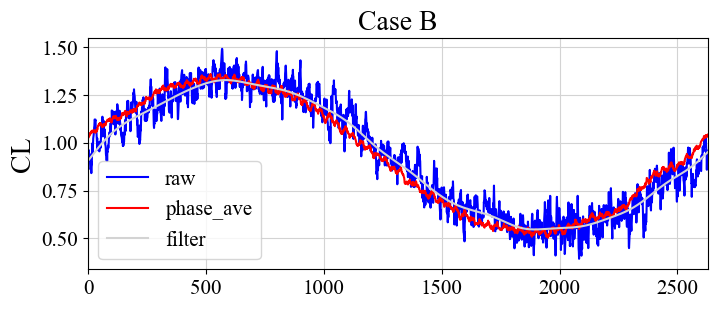

In [64]:
case_to_show = 'B'
port_to_show_cn = 1

if case_to_show in ['A', 'C', 'D', 'F']:
    len_one_cycle = len(data_f_individual['A'][:, 0]) // (2*num_files)
else:  # cases B and E
    len_one_cycle = len(data_f_individual['B'][:, 0]) // (5*num_files)
    
if port_to_show_cn == 0:
    temppp_cn = filtfilt(b, a, data_f_individual[case_to_show][:,0])
elif port_to_show_cn == 1:
    temppp_cn = filtfilt(b, a, data_f_individual[case_to_show][:,1])
else:
    temppp_cn = filtfilt(b, a, data_f_individual[case_to_show][:,2])

print(len_one_cycle)
        
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(data_f_individual[case_to_show][0:len_one_cycle,port_to_show_cn], label='raw', color='blue')
ax.plot(phase_av_cn[case_to_show][:,port_to_show_cn], label='phase_ave', color='red')
ax.plot(temppp_cn[0:len_one_cycle], label='filter', color='lightgray')
if port_to_show_cn == 0:
    y_label = 'CD'
elif port_to_show_cn == 1:
    y_label = 'CL'
else:
    y_label = 'CM'
ax.set_ylabel(y_label, fontsize=20)
# ax.set_ylim([-10,4])
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xmargin(0)
ax.grid(color='lightgray')
ax.set_title('Case '+case_to_show, fontsize=20)
# plt.savefig('cn_phase_ave.svg', bbox_inches='tight', dpi=350)

**check the periodic data**

Text(0, 0.5, 'fy')

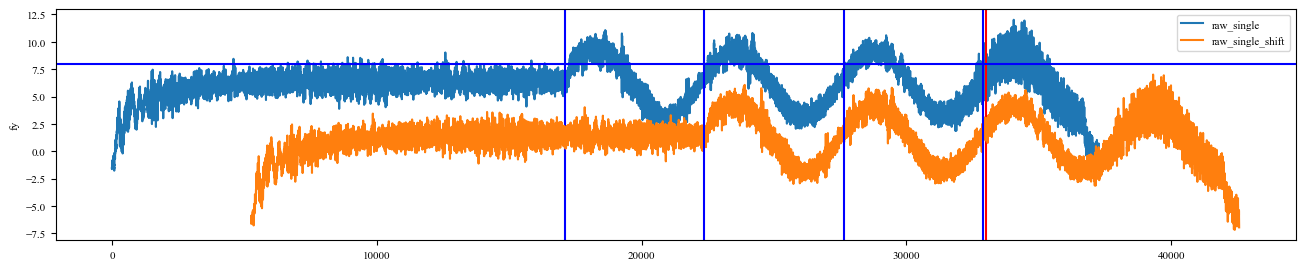

In [50]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(data_raw['A',6]['fy'], label='raw_single')
ax.axvline(x=nDataPoints+100, color='r')
ax.axvline(x=nMotionStart, color='b')
# define the length of one period
ax.plot(np.linspace(0+len_period,37300+len_period,37300), data_raw['A',6]['fy']-5, label='raw_single_shift')
ax.axvline(x=nMotionStart+len_period*1, color='b')
ax.axvline(x=nMotionStart+len_period*2, color='b')
ax.axvline(x=nMotionStart+len_period*3, color='b')
ax.axhline(y=8, color='b')
ax.legend()
ax.set_ylabel('fy')

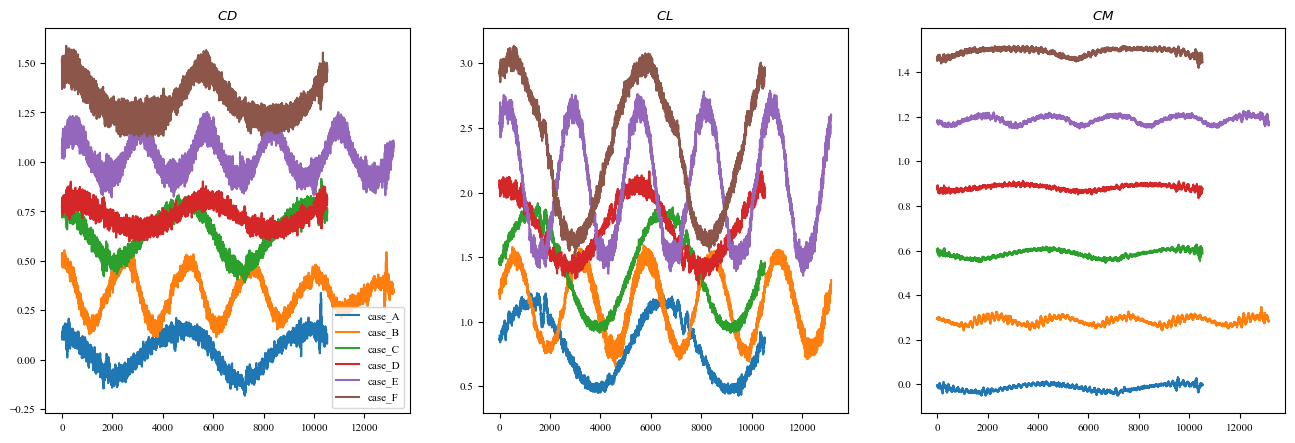

In [51]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for j in [0,1,2]:
    i=0
    for k in Case:
        ax[j].plot(CN[k][:,j]+0.3*i,label='case_'+k) # plus 0.3*i to distinguish them
        i = i+1
    if j == 0:
        ax[j].set_title('$CD$')
    if j == 1:
        ax[j].set_title('$CL$')
    if j == 2:
        ax[j].set_title('$CM$')
ax[0].legend()
# plt.tight_layout()

**Plot all forces of dynamic cases together**

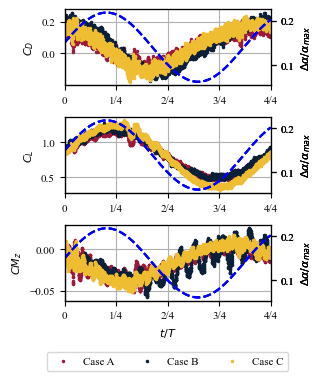

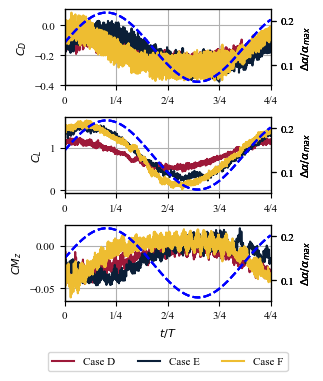

In [52]:
# convert all the six cases into one period, for camprasion
# for case a


Cases   = ['A', 'B', 'C']
ncases  = np.size(Cases) # number of cases to post-process
RefFreq = [0.19, 0.38, 0.19]

# Angle-of-attack, AoA = AoA(t)
time = np.linspace(0, 1, 100)
AoA_motion = AoA[nMotionStart:nMotionStart+len_period]

# * * * * * * * * * * * * * *
# plot all pitching cases
axs = plt.figure(figsize=(8.6*cm2in, 10*cm2in)).subplots(3,1)
limits = [-0.05, 0.15, 0.0, 1.5, -0.05, 0.05]

names  = ['$C_D$', '$C_L$', '$CM_z$'] # names of variables
for n in ['A','B','C']:
    i = 0   
    j = 0
    p = 0
    Icon, Color = myCases(n)

    for ax in axs.flat:
        if n == 'A':
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'B': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,int(len_period/2)),CN[n][0:int(len_period/2),i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'C': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        else:
            print('Error')
        
        ax.grid()
        ax.xaxis.get_label().set_fontsize(8)
        ax.yaxis.get_label().set_fontsize(8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(ylabel=names[i], fontsize = 8)

        # Set x-axis to multiples of t/T/4
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(['0','1/4','2/4','3/4', '4/4'])

        # Update for next iteration:
        i=i+1
        j=j+2
        
        # Create second axis for AoA:
        ax2=ax.twinx()
        ax2.plot(np.linspace(0,1,len_period), AoA_motion[0:len_period,0], 'b--')
        ax2.set(ylabel=r'$\Delta \alpha/\alpha_{max}$')
        
        ax.margins(x=0)
        
    p = p+1
    
ax.set_xlabel(r'$t/T$', fontsize = 8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6),fancybox=True, ncol=3)

plt.tight_layout()
plt.savefig('./Outputs/ForceCoefess_PitchingMotion.png', bbox_inches='tight', dpi=350)
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
# plot all plunging cases

Cases   = ['D', 'E', 'F']
ncases  = np.size(Cases) # number of cases to post-process
axs = plt.figure(figsize=(8.6*cm2in, 10*cm2in)).subplots(3,1)

for n in ['D','E','F']:
    i = 0   
    j = 0
    p = 0
    Icon, Color = myCases(n)

    for ax in axs.flat:
        if n == 'D':
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'E': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,int(len_period/2)),CN[n][0:int(len_period/2),i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'F': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        else:
            print('Error')
        
        ax.grid()
        ax.xaxis.get_label().set_fontsize(8)
        ax.yaxis.get_label().set_fontsize(8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(ylabel=names[i], fontsize = 8)

        #  Set x-axis to multiples of t/T/4
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(['0','1/4','2/4','3/4', '4/4'])

        # Update for next iteration:
        i=i+1
        j=j+2
        
        # Create second axis for AoA:
        ax2=ax.twinx()
        ax2.plot(np.linspace(0,1,len_period), AoA_motion[0:len_period,0], 'b--')
        ax2.set(ylabel=r'$\Delta \alpha/\alpha_{max}$')
        
        ax.margins(x=0)
        
    p = p+1
    
ax.set_xlabel(r'$t/T$', fontsize = 8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6),fancybox=True, ncol=3)

plt.tight_layout()
# plt.savefig('./Outputs/ForceCoefess_PlungingMotion.png', bbox_inches='tight', dpi=350)
# * * * * * * * * * * * * * *


## Plot pressure contours for steady case


==> This code runs OK


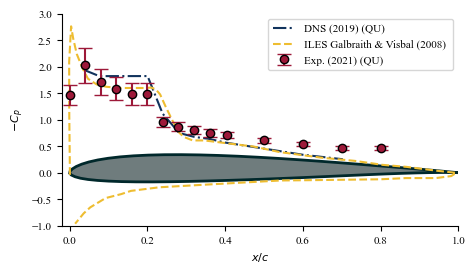

In [53]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

markers = ['.', ':s', ':o']
colours = ['#061D38', '#061D38', '#061D38']
labels =  [r'DNS (2019) (QU)', 'G&V (2008)','Exp. (QU)'] 

# Import reference pressure data
cp_DNS = pd.read_csv('./inputs/reference/cp_DNS.csv',            skiprows=1, sep=',', usecols = [0,1]).to_numpy()
cp_GV8 = pd.read_csv('./inputs/reference/cp_Galbraith_AoA8.csv', skiprows=1, sep=',', usecols = [0,1]).to_numpy()

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Folder = './inputs/experiments/Steady/AoA8/'
num_files       = 10 # number of files
num_extra_files = 3 # number of extra pressure ports
skiplines  = 15000  # skip transient stage
nt         = 15000  # desired length of data 
filterFreq = 1      # cut-off frequency for filter

# this is the order of the measured pressure ports
Columns10 = [0,2,3,4,5,6,7,8,9,10,11] # np.linspace(0,nports+1,nports,dtype=int)
Names10   = ['id','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
nports1   = 10

Columns5  = [0,2,3,4,5,6,7]
Names5    = ['id','p1','p15','p14','p13','p12','p11']
nports2   = 6

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# First 10 pressure ports
data_raw = {}
for i in range(num_files):
    fileName = 'Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10).to_numpy()
    idata    = np.mean(idata[:,1:],axis=0) # take only the average forward
    
    fileName    = 'Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    data_raw[i] = pd.read_csv(Folder+fileName, skiprows=skiplines, sep=',', usecols=Columns10, names=Names10).to_numpy()
    data        = data_raw[i][:nt,1:]

    # fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]
    # Correct pressure values
    idata[0]  = -idata[0]*fix[0]  # 0 is from the absolute sensor, which is always position values
    data[:,0] = -data[:,0]*fix[0] # so here we need to convert it to negative value, since it is the pressure above water surface
    for j in range(1,nports1):
        idata[j]  = idata[j]*fix[j]  + idata[0]
        data[:,j] = data[:,j]*fix[j] + data[:,0]
    
    # Calculate average of the solution:
    if i == 0:
        Data10 = np.zeros((nt, nports1))
    else:
        Data10 = Data10 + data - idata

# Calculate average:
Data10 = Data10/num_files

# Last 5 pressure ports * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Data5  = np.zeros([nt,nports2])  # original data
data_raw = {}
for i in range(num_extra_files):   
    fileName = 'extra_pressure_ports/Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5).to_numpy()
    idata    = np.mean(idata[:,1:],axis=0) # take only the average forward

    fileName    = 'extra_pressure_ports/Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    data_raw[i] = pd.read_csv(Folder+fileName, skiprows=skiplines, sep=',', usecols=Columns5, names=Names5).to_numpy()
    data        = data_raw[i][:nt,1:]

    # Correct pressure values
    idata[0]  = -idata[0]*fix[0]  # 0 is from the absolute sensor, which is always position values
    data[:,0] = -data[:,0]*fix[0] # so here we need to convert it to negative value, since it is the pressure above water surface
    for j in range(1,nports2):
        idata[j]  = idata[j]*fix[j]  + idata[0]
        data[:,j] = data[:,j]*fix[j] + data[:,0]

    # Calculate average of the solution:
    if i==0:
        Data5 = np.zeros((nt,nports2))
    else:
        Data5 = Data5 + data - idata

# Calculate average:
Data5 = Data5/num_extra_files

#   * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
# Create pressure value:
Data = np.zeros((nt,nports1+nports2-1))
Data_filt = np.zeros((nt,nports1+nports2-1))
Data[:,0:nports1]  = Data10
Data[:,nports1:] = Data5[:,1:]
Data = Data - 35

# filter the data using Bessel filter
from scipy.signal import filtfilt
from scipy.signal import bessel
b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
for i in range(15):
    Data_filt[:,i] = filtfilt(b, a, Data[:,i])
p = np.mean(Data_filt,axis=0) #- 35 # pressure is equal to the average over time minus absolute value; 
                              # -35pa is calibration due to unevenness of the traverse
    
# Calculate loads using coefficient (with uncertainty)
# uncertainty: u(P) = sqrt(u_sys^2 + u_rand^2)
# px409: 0.25pa
# uncertainty due to the resolution: 0.25/2=0.125pa (half of resolution);
# the systematic uncertainty is 0.08%: 2500*0.08%=2pa
# and the standard deviation

stds_p = np.std(Data_filt[5000:,:],axis=0)
d_p    = np.sqrt((0.125)**2 + (2)**2 + (stds_p)**2)
Cp     = p / (0.5*rho*u**2)
d_Cp   = np.sqrt((1 / (0.5 * rho * u**2) * d_p) ** 2 + 
                 (p / ( 0.5 * rho**2 * u**2) * drho) ** 2 + 
                 (2*p / (0.5 * rho * u**3) * du) ** 2)
#   * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

# Plot results
fig, ax = plt.subplots(figsize=(13*cm2in, 7*cm2in))

ax.set_ylabel(r'$-C_p$')
ax.set_xlabel('$x/c$')
ax.set_xlim([-0.02, 1])
ax.set_ylim([-1.0,3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Draw airfoil:
ax.fill(xs,ys, edgecolor='#00282b', facecolor='#6f7c7d',linewidth=2) 

# Add reference data:
plt.plot(cp_DNS[:,0],-cp_DNS[:,1],'-.', color='#11335d',label = 'DNS (2019) (QU)')
plt.plot(cp_GV8[:,0],cp_GV8[:,1],'--', color='#eebd31',label = 'ILES Galbraith & Visbal (2008) ')

# Plot experiment data:
# ax.plot(xports,-p/dynP,'o', markerfacecolor='#9d1939', markeredgecolor='#000000',label = 'Exp. (2021) (QU)', linewidth=2.5)
ax.errorbar(xports,-Cp,yerr=abs(d_Cp*Cp), fmt='o', ecolor='#9d1939', 
            markerfacecolor='#9d1939', markeredgecolor='#000000', capsize=5,
            label = 'Exp. (2021) (QU)', linewidth=1.5)

# Add legendes:
ax.legend(loc='best')

plt.savefig('./Outputs/PressureCoeffs_Steady.png', bbox_inches='tight', dpi=300)

print("\n==> This code runs OK")

### Post-process pressure contours for dynamic cases

Use the following parametes:
- Case 'A':
    - RefFreq: 0.19
- Case 'B':
    - RefFreq: 0.38
- Case 'C':
    - RefFreq: 0.19
- Case 'D':
    - RefFreq: 0.19
- Case 'E':
    - RefFreq: 0.38
- Case 'F':
    - RefFreq: 0.19

In [71]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# First 10 pressure ports 
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Case      = ['A','B','C','D','E','F']
Cp_dyna   = {}
Cp_dyna      = {}
data_raw_10  = {} # initialize a dictionary, with keys and values
data_raw_5   = {} # initialize a dictionary, with keys and values
data_p10_individual = {} # the first 10 pressure ports
data_p5_individual  = {} # the last 5 pressure ports
data_p_individual   = {} # the combined Cp
data_p_individual_temp  = {}
data_p_individual_filt  = {}
Cp_dyna_individual      = {}
Cp_dyna_individual_filt = {}
data_p10_individual_filt = {}
data_p5_individual_filt  = {}
data_p_individual_filt_temp = {}

Names10   = ['id','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
Names5    = ['id','p1','p15','p14','p13','p12','p11']

for k in Case:
    # First 10 pressure ports 
    Folder = './inputs/experiments/Case' + k + '/'
    print(Folder)
    if k in ['A','B','C']:
        nMotionStart = 17600
        nDataPoints  = nMotionStart + len_period*3
    else:
        nMotionStart = 17300
        nDataPoints  = nMotionStart + len_period*3

    Data_10 = np.zeros((nDataPoints,nports1))
    for i in range(num_files):
        fileName = 'Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10).to_numpy()
        idata    = np.mean(idata[:,1:],axis=0) # take only the average forward. drop the 'id' column

        fileName = 'Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw_10[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10, names=Names10)
        data     = data_raw_10[k,i][Names10[1:]].copy().to_numpy() # transform data to numpy array. drop the 'id' column

        # fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]
        # Correct pressure values
        idata[0]  = -idata[0]*fix[0]
        data[:,0] = -data[:,0]*fix[0]
        for j in range(1,nports1):
            idata[j]  = idata[j]*fix[j]  + idata[0]
            data[:,j] = data[:,j]*fix[j] + data[:,0]
        
        # pressure coefficient for individual runs. -35 pa is the calibration
        data_p10_individual[k,i] = (data - idata - 35) / dynP
        
        # filter the data for individual run
        data_p10_individual_filt[k,i] = np.zeros_like(data_p10_individual[k,i])
        for j in range(10):
            data_p10_individual_filt[k,i][:,j] = filtfilt(b, a, data_p10_individual[k,i][:,j])

        # Calculate average of the solution:
        if i==0:
            Data_10 = np.zeros((nDataPoints,nports1))
        else:
            Data_10 = Data_10 + data[0:nDataPoints,:] - idata

    # Calculate average:
    Data_10 = Data_10/num_files
    
    # Last 5 pressure ports
    Data_5 = np.zeros((nDataPoints,nports2))
    for i in range(num_files):   
        fileName = 'extra_pressure_ports/Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5).to_numpy()
        idata    = np.mean(idata[:,1:],axis=0) # take only the average forward. drop the 'id' column

        fileName   = 'extra_pressure_ports/Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw_5[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5, names=Names5)
        data       = data_raw_5[k,i][Names5[1:]].copy().to_numpy() # transform data to numpy array. drop the 'id' column

        # Correct pressure values        
        idata[0]  = -idata[0]*fix[0]
        data[:,0] = -data[:,0]*fix[0]
        for j in range(1,nports2):
            idata[j]  = idata[j]*fix[j]  + idata[0]
            data[:,j] = data[:,j]*fix[j] + data[:,0]
            
        # pressure coefficient for individual runs. -35 pa is the calibration
        data_p5_individual[k,i] = (data[:,1:] - idata[1:] - 35) / dynP # drop the first column, as it is already in the p10
        
        # filter the data for individual run
        data_p5_individual_filt[k,i] = np.zeros_like(data_p5_individual[k,i])
        
        for j in range(5):
            data_p5_individual_filt[k,i][:,j] = filtfilt(b, a, data_p5_individual[k,i][:,j])

        # Calculate average of the solution:
        if i==0:
            Data_5 = np.zeros((nDataPoints,nports2))
        else:
            Data_5 = Data_5 + data[0:nDataPoints,:] - idata

    # Calculate average:
    Data_5 = Data_5/num_extra_files
    
    # Create pressure value:
    Data = np.zeros((nDataPoints,nports1+nports2-1))
    Data[:,0:nports1]  = Data_10
    Data[:,nports1:]   = Data_5[:,1:]
    
    # calibrate by 35 pa
    Data = Data - 35  # mean value
    
    # filter data and calculate Cp for the mean pressure
    for i in range(15):
        Data[:,i] = filtfilt(b, a, Data[:,i]) / dynP # mean value
    
    # combine the first 10 and last 5 pressure taps
    if k in ['A','C','D','F']:
        for i in range(num_files):
            data_p_individual_temp[k,i] = np.concatenate((data_p10_individual[k,i][nMotionStart+len_period:nDataPoints,:], 
                                                          data_p5_individual[k,i][nMotionStart+len_period:nDataPoints,:]), axis=1)
            data_p_individual_filt_temp[k,i] = np.concatenate((data_p10_individual_filt[k,i][nMotionStart+len_period:nDataPoints,:],
                                                               data_p5_individual_filt[k,i][nMotionStart+len_period:nDataPoints,:]), axis=1)
        # combine the pressure individual runs
        data_p_individual[k] = data_p_individual_temp[k,0]
        data_p_individual_filt[k] = data_p_individual_filt_temp[k,0]
        for j in range(1,num_files):
            data_p_individual[k] = np.concatenate((data_p_individual[k], data_p_individual_temp[k,j]), axis=0)
            data_p_individual_filt[k] = np.concatenate((data_p_individual_filt[k], data_p_individual_filt_temp[k,j]), axis=0)

        # save the unsteady data
        Cp_dyna[k] = Data[nMotionStart+len_period:nDataPoints] # mean value
    else:
        for i in range(num_files):
            data_p_individual_temp[k,i] = np.concatenate((data_p10_individual[k,i][nMotionStart+int(len_period/2):nDataPoints,:], 
                                                          data_p5_individual[k,i][nMotionStart+int(len_period/2):nDataPoints,:]), axis=1)
            data_p_individual_filt_temp[k,i] = np.concatenate((data_p10_individual_filt[k,i][nMotionStart+int(len_period/2):nDataPoints,:],
                                                               data_p5_individual_filt[k,i][nMotionStart+int(len_period/2):nDataPoints,:]), axis=1)
        # combine the pressure individual runs
        data_p_individual[k] = data_p_individual_temp[k,0]
        data_p_individual_filt[k] = data_p_individual_filt_temp[k,0]
        for j in range(1,num_files):
            data_p_individual[k] = np.concatenate((data_p_individual[k], data_p_individual_temp[k,j]), axis=0)
            data_p_individual_filt[k] = np.concatenate((data_p_individual_filt[k], data_p_individual_filt_temp[k,j]), axis=0)

        # save the unsteady data
        Cp_dyna[k] = Data[nMotionStart+int(len_period/2):nDataPoints] # mean value
    
print('done')

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/
done


### show the individual run, filtered

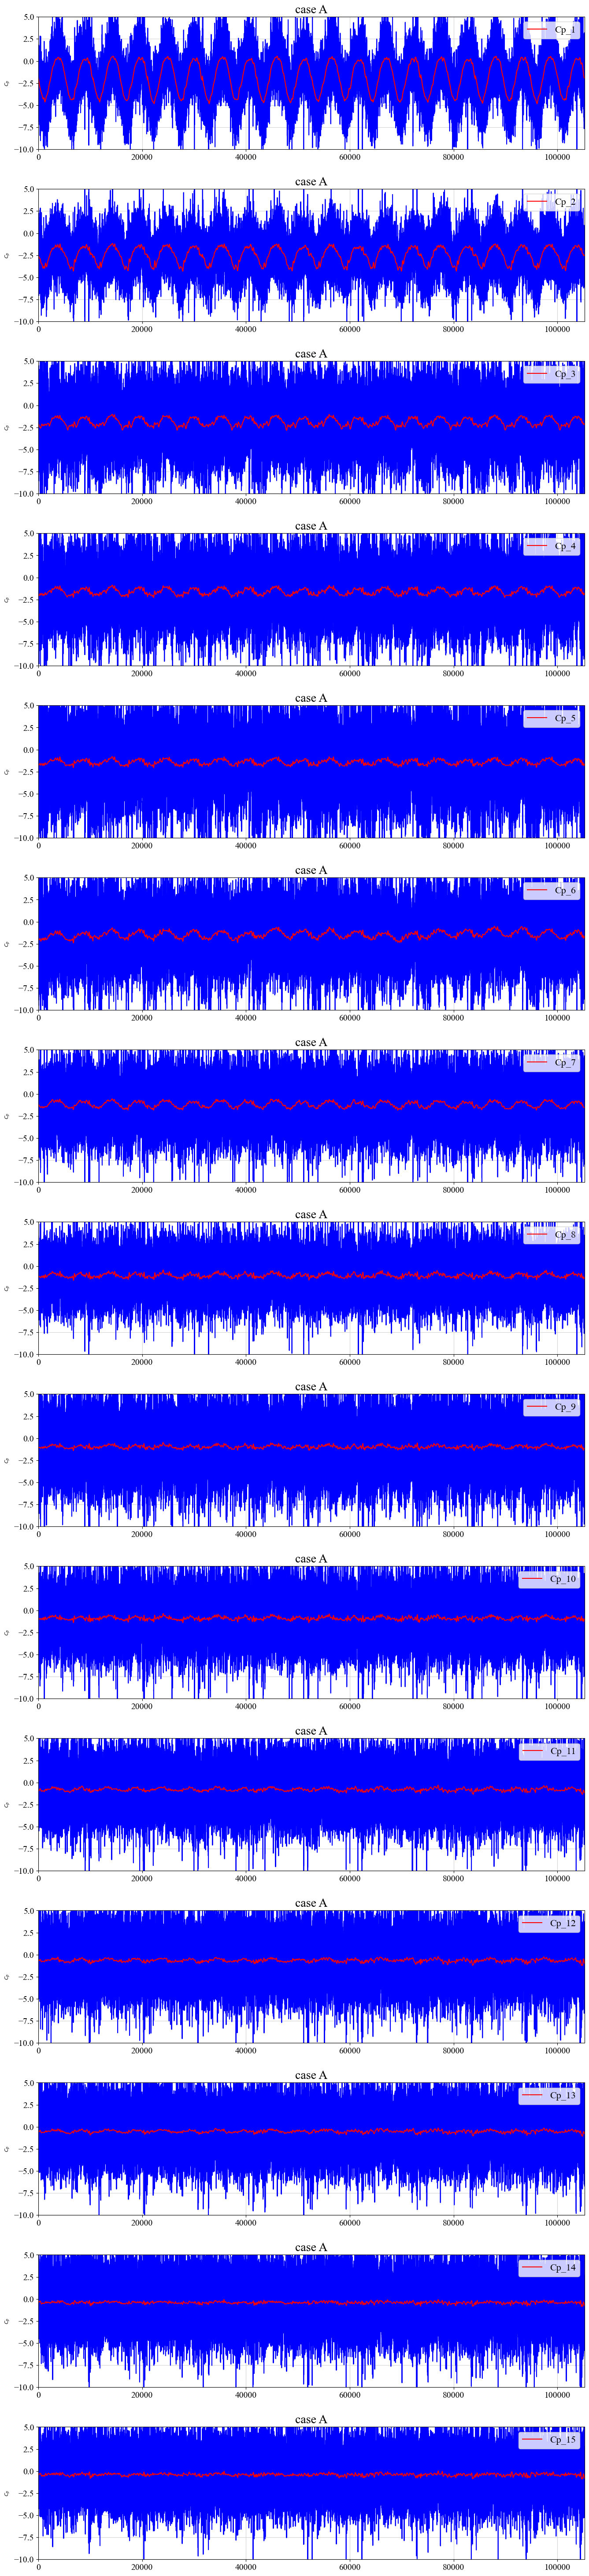

In [56]:
case_to_show = 'A'
show_end = 15780
num_port_show = 15
len_cycle = 5262
fig, ax = plt.subplots(num_port_show,1,figsize=(16,5*num_port_show))
# Set the height ratio of the subplots
fig.subplots_adjust(hspace=0.3)
for port_to_show in range(num_port_show):
    ax[port_to_show].plot(data_p_individual[case_to_show][0:len_cycle*20,port_to_show],'b')
    ax[port_to_show].plot(data_p_individual_filt[case_to_show][0:len_cycle*20,port_to_show], 'r', label='Cp_'+str(port_to_show+1))
    ax[port_to_show].margins(x=0)
    ax[port_to_show].grid(color='lightgray')
    ax[port_to_show].legend(fontsize=16, loc='upper right')
    ax[port_to_show].set_ylabel('$C_p$')
    ax[port_to_show].set_title('case ' + case_to_show, loc='center', y=1, fontsize=20)
    # Set font size of tick labels
    ax[port_to_show].tick_params(axis='x', labelsize=14)
    ax[port_to_show].tick_params(axis='y', labelsize=14)
    ax[port_to_show].set_ylim(-10,5)
plt.savefig('cp_indiv_filt_caseA.png', bbox_inches='tight', dpi=350)

**phase average the raw individual run data**

In [72]:
phase_av_cp = {}

for j in Case: # 6 cases
    if j in ['A', 'C', 'D', 'F']:
        len_one_cycle = len(data_p_individual[j][:, 0]) // (2*num_files)
    else:  # cases B and E
        len_one_cycle = len(data_p_individual[j][:, 0]) // (5*num_files)

    avgs = []  # Use a list to store the average pressures for each port

    for k in range(15): # 15 pressure ports
        phase_sum = np.zeros(len_one_cycle)  # Initialize phase_sum inside the loop
        if j in ['A', 'C', 'D', 'F']:   # A C D F have 20 cycles
            for i in range((2*num_files)):
                phase_sum = phase_sum + data_p_individual[j][len_one_cycle*i:len_one_cycle*(i+1),k]
            avg_phase = phase_sum / (2*num_files)
        else:
            for i in range((5*num_files)): # B E have 50 cycles
                phase_sum = phase_sum + data_p_individual[j][len_one_cycle*i:len_one_cycle*(i+1),k]
            avg_phase = phase_sum / (5*num_files)
        
        avgs.append(avg_phase)

    phase_av_cp[j] = np.column_stack(avgs)  # Convert the list of averages to a numpy array
print('Done!')

Done!


5262


Text(0.5, 1.0, 'Case A| $C_p$$_{1}$')

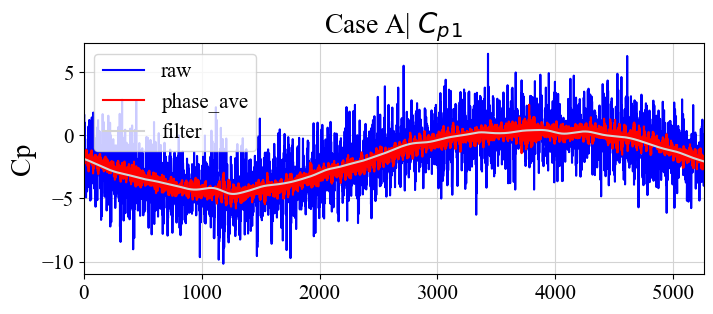

In [80]:
case_to_show = 'A'
port_to_show_p = 0

if case_to_show in ['A', 'C', 'D', 'F']:
    len_one_cycle = len(data_p_individual['A'][:, 0]) // (2*num_files)
else:  # cases B and E
    len_one_cycle = len(data_p_individual['B'][:, 0]) // (5*num_files)

print(len_one_cycle)
        
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(data_p_individual[case_to_show][0:len_one_cycle,port_to_show_p], label='raw', color='blue')
ax.plot(phase_av_cp[case_to_show][:,port_to_show_p], label='phase_ave', color='red')
temppp_cp = data_p_individual_filt[case_to_show][0:len_one_cycle,port_to_show_p]
ax.plot(temppp_cp, label='filter', color='lightgray')
ax.set_ylabel('Cp', fontsize=20)
# ax.set_ylim([-10,4])
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xmargin(0)
ax.grid(color='lightgray')
ax.set_title('Case '+case_to_show + '| $C_p$' + r'${}_{{{}}}$'.format('', port_to_show_p+1), fontsize=20)
# plt.savefig('cp_phase_ave.svg', bbox_inches='tight', dpi=350)

**combine cp and cn together and save as pandas dataframe**

In [81]:
import pandas as pd
columnName = ['cp1', 'cp2', 'cp3', 'cp4', 'cp5', 'cp6', 'cp7', 'cp8', 
              'cp9', 'cp10', 'cp11', 'cp12', 'cp13', 'cp14', 'cp15', 
              'cd', 'cl', 'cm',
              'cp1_phaseAve', 'cp2_phaseAve', 'cp3_phaseAve', 'cp4_phaseAve', 'cp5_phaseAve', 
              'cp6_phaseAve', 'cp7_phaseAve', 'cp8_phaseAve', 'cp9_phaseAve', 'cp10_phaseAve', 
              'cp11_phaseAve', 'cp12_phaseAve', 'cp13_phaseAve', 'cp14_phaseAve', 'cp15_phaseAve',
              'cd_phaseAve', 'cl_phaseAve', 'cm_phaseAve']

df_sd7003_temp = {}

for k in Case:
    if k in ['A', 'C', 'D', 'F']:
        repeat_count = 20
    else:  # cases B and E
        repeat_count = 50

    # repeat the phase data to match the length of the individual raw data
    phase_av_cp_repeated = np.tile(phase_av_cp[k], (repeat_count, 1))
    phase_av_cn_repeated = np.tile(phase_av_cn[k], (repeat_count, 1))

    sd7003_temp = np.concatenate((data_p_individual[k], data_f_individual[k],
                                  phase_av_cp_repeated, phase_av_cn_repeated), axis=1)
    
    df_sd7003_temp[k] = pd.DataFrame(sd7003_temp, index=['case_'+k]*sd7003_temp.shape[0], columns=columnName)

# combine DataFrames into one larger DataFrame
df_sd7003 = pd.concat(df_sd7003_temp.values())

# Save the DataFrame to a .csv file
df_sd7003.to_csv('sd7003_data.csv', index_label='Case')

print('Done!')

Done!


In [82]:
df_sd7003.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,...,cp9_phaseAve,cp10_phaseAve,cp11_phaseAve,cp12_phaseAve,cp13_phaseAve,cp14_phaseAve,cp15_phaseAve,cd_phaseAve,cl_phaseAve,cm_phaseAve
case_A,0.247487,-3.737755,-5.724337,0.236118,-0.521526,2.643322,2.347775,1.796782,3.939303,2.496263,...,-1.274556,-1.270892,-1.032935,-0.282485,-0.475006,-0.088007,-0.178865,0.133783,0.983149,-0.008814
case_A,0.807860,-2.247096,-5.370898,0.825791,-1.279671,2.355813,2.204938,2.320529,4.761548,3.649968,...,-1.028175,-1.001162,-0.464761,0.145322,0.123842,0.359119,0.354606,0.140490,0.974227,-0.008250
case_A,1.654645,-1.772059,-5.547794,1.342948,-1.484036,2.378525,3.630406,3.442006,6.320699,5.306177,...,-1.367914,-1.402981,-0.969865,-0.216943,-0.329712,0.038424,-0.043368,0.148153,0.969675,-0.007453
case_A,-1.782306,-5.139422,-8.686247,-2.121472,-5.948330,-1.858694,0.559710,0.473861,3.385518,2.334369,...,-1.380513,-1.500460,-0.947762,-0.317626,-0.255509,0.074354,-0.022638,0.145074,0.959564,-0.008233
case_A,-3.027578,-5.787699,-9.695286,-3.273350,-8.700739,-4.336414,-0.976735,-0.595609,2.224484,1.356463,...,-1.768579,-1.796870,-0.807888,-0.257871,-0.078460,0.133652,0.077130,0.158174,0.959444,-0.006937


**plot the individual raw data and the phase average data**

(0.0, 4.5)

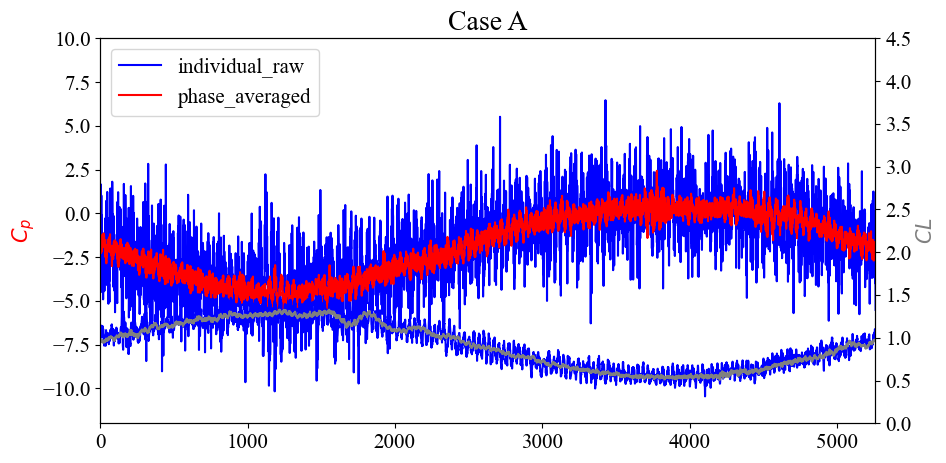

In [84]:
# set which case to show
case_check  = 'A' # ['A','B','C','D','E','F',]
port_check  = 1 # [1,2,...15]
force_check = 'cl'  # (cd cl cm)

# plot data
case_cp = df_sd7003.loc['case_'+case_check]['cp'+str(port_check)].to_numpy()
case_cp_phaseave = df_sd7003.loc['case_'+case_check]['cp'+str(port_check)+'_phaseAve'].to_numpy()
case_cn = df_sd7003.loc['case_'+case_check][force_check].to_numpy()
case_cn_phaseave = df_sd7003.loc['case_'+case_check][force_check+'_phaseAve'].to_numpy()


fig,ax=plt.subplots(figsize=(10,5))
ax.plot(case_cp, 'b', label='individual_raw')
ax.plot(case_cp_phaseave,'r' , label='phase_averaged')
ax.set_ylabel('$C_p$', color='r', fontsize=15)
ax.set_xmargin(0)
ax.legend(fontsize=15)
ax.set_xlim([0,len_period])
ax.set_ylim([-12,10])
ax.set_title('Case '+case_to_show, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

ax2 = ax.twinx()
ax2.plot(case_cn, 'b', label='individual_raw')
ax2.plot(case_cn_phaseave, 'gray', label='phase_averaged')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('$CL$', color='gray', fontsize=15)
ax2.set_ylim([0,4.5])


**calculate the lag using cross correlation**

In [86]:
from scipy.signal import correlate
corr = correlate(case_cp_phaseave[0:len_one_cycle], case_cn_phaseave[0:len_one_cycle], mode='full')
print('the lag of pressure and lift is: ', np.argmax(corr))

the lag of pressure and lift is:  10522


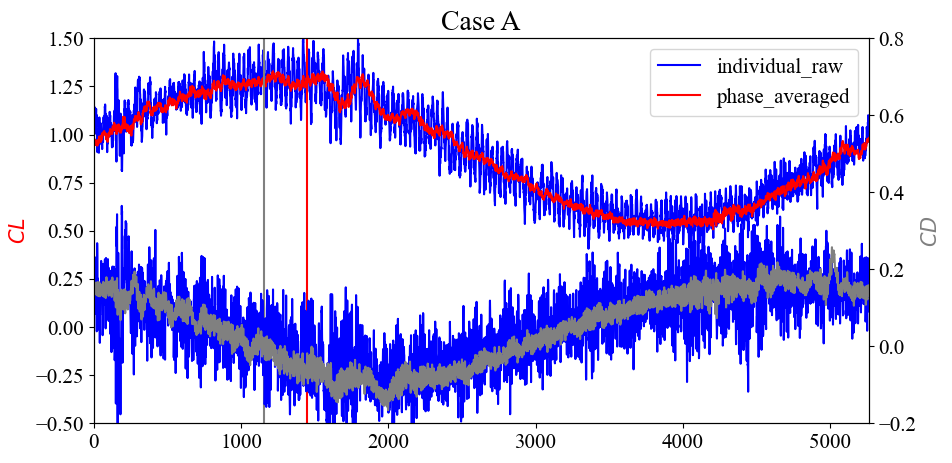

In [87]:
# set which case to show
case_check  = 'A' # ['A','B','C','D','E','F',]
port_check  = 1 # [1,2,...15]

# plot data
case_cl = df_sd7003.loc['case_'+case_check]['cl'].to_numpy()
case_cl_phaseave = df_sd7003.loc['case_'+case_check]['cl'+'_phaseAve'].to_numpy()
case_cd = df_sd7003.loc['case_'+case_check]['cd'].to_numpy()
case_cd_phaseave = df_sd7003.loc['case_'+case_check]['cd'+'_phaseAve'].to_numpy()


fig,ax=plt.subplots(figsize=(10,5))
ax.plot(case_cl, 'b', label='individual_raw')
ax.plot(case_cl_phaseave,'r' , label='phase_averaged')
ax.set_ylabel('$CL$', color='r', fontsize=15)
ax.set_xmargin(0)
ax.legend(fontsize=15)
ax.set_xlim([0,len_period])
ax.set_ylim([-0.5,1.5])
ax.set_title('Case '+case_check, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

ax2 = ax.twinx()
ax2.plot(case_cd, 'b', label='individual_raw')
ax2.plot(case_cd_phaseave, 'gray', label='phase_averaged')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('$CD$', color='gray', fontsize=15)
ax2.set_ylim([-0.2,0.8])

ax.axvline(x=1450, color='r')
ax.axvline(x=1154, color='gray')